# Masking Data Land-Sea Masks (Advanced)<a id='top' class="tocSkip"> </a>

In this example we will show more ways to generate masks, including land/sea masks.


The CDAT software was developed by LLNL. This tutorial was written by Charles Doutriaux. This work was performed under the auspices of the U.S. Department of Energy by Lawrence Livermore National Laboratory under Contract DE-AC52-07NA27344.

[Download the Jupyter Notebook](Masking_Data_Land-Sea_Advanced.ipynb)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preparing-the-Notebook" data-toc-modified-id="Preparing-the-Notebook-1">Preparing the Notebook</a></span></li><li><span><a href="#Value-based-masks" data-toc-modified-id="Value-based-masks-2">Value based masks</a></span></li><li><span><a href="#Land-sea-Masks" data-toc-modified-id="Land-sea-Masks-3">Land-sea Masks</a></span><ul class="toc-item"><li><span><a href="#Generating-a-Land-sea-Mask-on-any-grid" data-toc-modified-id="Generating-a-Land-sea-Mask-on-any-grid-3.1">Generating a Land-sea Mask on any grid</a></span></li><li><span><a href="#Surface-type-by-region-masks" data-toc-modified-id="Surface-type-by-region-masks-3.2">Surface type by region masks</a></span></li></ul></li></ul></div>

## Preparing the Notebook
[Back to Top](#top)

In [3]:
import requests
r = requests.get("https://cdat.llnl.gov/cdat/sample_data/clt.nc",stream=True)
with open("clt.nc","wb") as f:
    for chunk in r.iter_content(chunk_size=1024):
        if chunk:  # filter local_filename keep-alive new chunks
            f.write(chunk)

# and load data
import cdms2
f = cdms2.open("clt.nc")
clt = f("clt", time=slice(0,1), squeeze=1) # Get first month
u = f("u", level=slice(0,1), squeeze=1)
v = f("v", level=slice(0,1), squeeze=1)
clt = clt.regrid(u.getGrid(), regridTool="regrid2") # Put data on same grid

# computes wind speed
import MV2
speed = MV2.sqrt(u**2+v**2)
print("Max speed:", speed.max())
print("Mean speed:",speed.mean())
print("Min speed:",speed.min())

# Prepare graphics
import vcs
x=vcs.init()

Max speed: 68.91321
Mean speed: 16.25912330863402
Min speed: 0.061108682


## Value based masks
[Back to Top](#top)

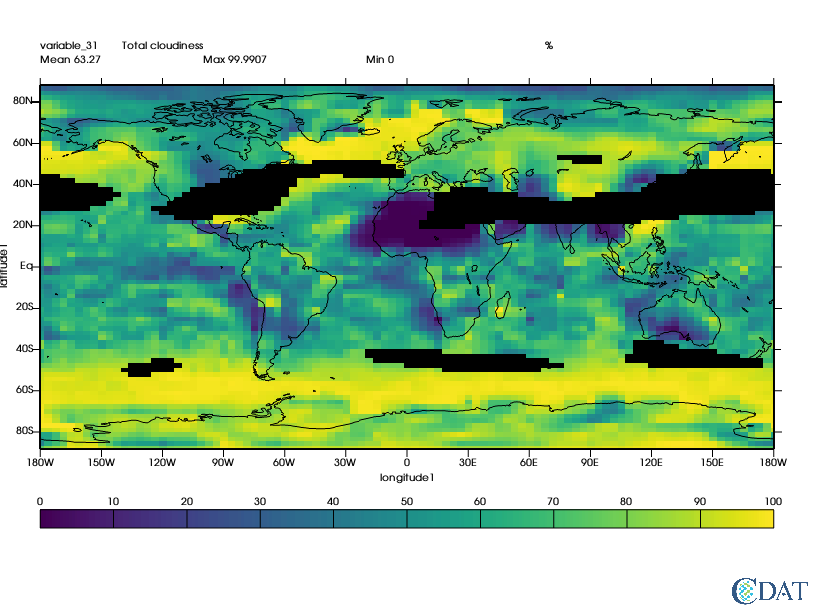

In [2]:
# Let's mask out area where wind speed is greater than twice mean
mask = MV2.greater(speed,speed.mean()*2.)

# Let's apply this mask
clt_masked = MV2.masked_where(mask,clt)
x.plot(clt_masked)

## Land-sea Masks
[Back to Top](#top)

### Generating a Land-sea Mask on any grid

Conveniently CDAT can generate masks for you (for regular grids only).

The observed data set used here as the basis for creating realistic model land/sea masks was obtained from the U.S. Navy on a 1/6 degree longitude-latitude grid.

More on the technique used can be read [here](https://www-pcmdi.llnl.gov/publications/pdf/58.pdf)

[Back to Top](#top)

In [ ]:
import cdutil
mask = cdutil.generateLandSeaMask(clt)
mask2 = MV2.where(mask._mask,1.,mask) # Not needed for cdutil versions >= 2.12.2017.9.25
mask2.setAxisList(mask.getAxisList()) # Not needed for cdutil versions >= 2.12.2017.9.25
clt_masked = MV2.masked_where(mask2,clt)
x.clear()
x.plot(clt_masked)

### Surface type by region masks

CDAT also provide capabilities to mask regions. Original regions and their numbers come from [EzGet](http://github.com/uv-cdat/ezget)

The function requires both a land/sea mask and a file reporting "regions", default "region" mask is as follow:
<img src="colorgeog.png">

Regions tables is:
<img src="table.png">

[Back to Top](#top)

In [ ]:
regions, guess = cdutil.generateSurfaceTypeByRegionMask(mask2*100., verbose=False)

In [ ]:
# let's take a look
x.clear()
x.plot(regions)

In [ ]:
# Now let's extract the indian ocean which according to table are area 205 and 206
ind1 = MV2.equal(regions,205)
ind2 = MV2.equal(regions,206)
indian_ocean = MV2.logical_or(ind1,ind2)

clt_indian_ocean = MV2.masked_where(MV2.logical_not(indian_ocean),clt)
x.clear()
x.plot(clt_indian_ocean(longitude=(15,150),latitude=(-90,35)),ratio="autot")